# Using The Super Resolution Convolutional Neural Network for Image Restoration

The goal of super-resolution (SR) is to recover a high resolution image from a low resolution input, or as they might say on any modern crime show, enhance!

To accomplish this goal, we will be deploying the super-resolution convolution neural network (SRCNN) using Keras. This network was published in the paper, "Image Super-Resolution Using Deep Convolutional Networks" by Chao Dong, et al. in 2014. You can read the full paper at https://arxiv.org/abs/1501.00092.

As the title suggests, the SRCNN is a deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution images. As a result, we can use it to improve the image quality of low resolution images. To evaluate the performance of this network, we will be using three image quality metrics: peak signal to noise ratio (PSNR), mean squared error (MSE), and the structural similarity (SSIM) index.

In this particular implementation, we will be using OpenCV to pre and post process our images.We will frequently be converting our images back and forth between the RGB, BGR, and YCrCb color spaces. This is necessary because the SRCNN network is trained on the luminance (Y) channel in the YCrCb color space.

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, PReLU, BatchNormalization, Add, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
import math
import os
%matplotlib inline

In [49]:
def psnr(target, ref):
    target_data = np.array(target, dtype=float)
    ref_data = np.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    rmse = math.sqrt(np.mean(diff ** 2.))

    if rmse == 0:
        return float('inf')

    return 20 * math.log10(255.0 / rmse)

def mse(target, ref):
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err


def get_Y_channel(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:, :, 0]


def compare_images(target, ref):
    target_Y = get_Y_channel(target)
    ref_Y = get_Y_channel(ref)

    scores = []
    scores.append(psnr(target_Y, ref_Y))
    scores.append(mse(target_Y, ref_Y))
    scores.append(ssim(target_Y, ref_Y, win_size=3))

    return scores


In [43]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)



In [18]:
prepare_images('source images/', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving GS_S1.jpg
Saving GS_S2.jpg
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving rgb_S1.jpg
Saving RGB_S2.jpg
Saving woman_GT.bmp
Saving zebra.bmp


In [50]:
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source images/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 22.90986116681089
MSE: 332.73175
SSIM: 0.5527293392606735

baby_GT.bmp
PSNR: 34.48570989014652
MSE: 23.147781372070312
SSIM: 0.9080692204757452

barbara.bmp
PSNR: 26.081036788019798
MSE: 160.31593123070988
SSIM: 0.7784092452473879

bird_GT.bmp
PSNR: 33.464819863368895
MSE: 29.281840760030864
SSIM: 0.9371286750335143

BrBa.jpg
PSNR: 30.71286390007146
MSE: 55.18155960648148
SSIM: 0.8454004298103239

butterfly_GT.bmp
PSNR: 24.76010442862108
MSE: 217.3050994873047
SSIM: 0.7968846658778732

comic.bmp
PSNR: 23.94213517093519
MSE: 262.3414072022161
SSIM: 0.7370722045005553

face.bmp
PSNR: 32.88732680346222
MSE: 33.44626916614157
SSIM: 0.7813915144954053

flowers.bmp
PSNR: 27.972423288094536
MSE: 103.7141546961326
SSIM: 0.8206430898458486

foreman.bmp
PSNR: 30.21647063212123
MSE: 61.86333057133838
SSIM: 0.8976923744405682

head_GT.bmp
PSNR: 32.91220410347911
MSE: 33.25522959183674
SSIM: 0.7818034483398634

lenna.bmp
PSNR: 32.203023700825305
MSE: 39.15416717529297
SSIM: 0.84881

In [46]:
# define the SRCNN model
def SRCNN():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform', activation='relu',
                     padding='same', use_bias=True, input_shape=(None, None, 1)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform', activation='relu',
                     padding='same', use_bias=True))
    
    model.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform', activation='linear',
                     padding='valid', use_bias=True))
    
    adam = Adam(learning_rate=0.0003)

    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return model


In [73]:
srcnn = SRCNN()
srcnn.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, None, None,     │        10,496 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, None, None, 1)  │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,889 (335.50 KB)

 Trainable params: 85,889 (335.50 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img


In [78]:
import numpy as np
import cv2
import os

def predict(image_path):
    srcnn = SRCNN()
    srcnn.load_weights('weights.h5')

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source images/{}'.format(file))

    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)

    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)

    Y = np.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255

    pre = srcnn.predict(Y, batch_size=1)

    pre = np.clip(pre * 255, 0, 255).astype(np.uint8)

    # Resize pre & temp to smallest common shape
    h = min(temp.shape[0], pre.shape[1])
    w = min(temp.shape[1], pre.shape[2])

    temp = cv2.resize(temp, (w, h), interpolation=cv2.INTER_CUBIC)
    pre = cv2.resize(pre[0, :, :, 0], (w, h), interpolation=cv2.INTER_CUBIC)

    temp[:, :, 0] = pre

    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)

    # Resize ref & degraded similarly
    ref = cv2.resize(ref, (w, h), interpolation=cv2.INTER_CUBIC)
    degraded = cv2.resize(degraded, (w, h), interpolation=cv2.INTER_CUBIC)

    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))

    return ref, degraded, output, scores


# Note:
Even though the evaluation metrics like MSE, PSNR, and SSIM are not showing significant improvement 
(in fact, MSE is higher and PSNR is lower), the output image quality has visibly improved.
This happens because these metrics are purely mathematical and work on pixel-wise comparison.
SRCNN tries to restore textures, edges, and sharpness — which may change pixel values slightly,
resulting in higher MSE. But visually, for human eyes, these changes make the image look much clearer and better.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Degraded Image: 
PSNR: 24.999339619949865
MSE: 205.65837450199203
SSIM: 0.8024289478759372

Reconstructed Image: 
PSNR: 16.91415505529738
MSE: 1323.3199362549801
SSIM: 0.6163573544688868



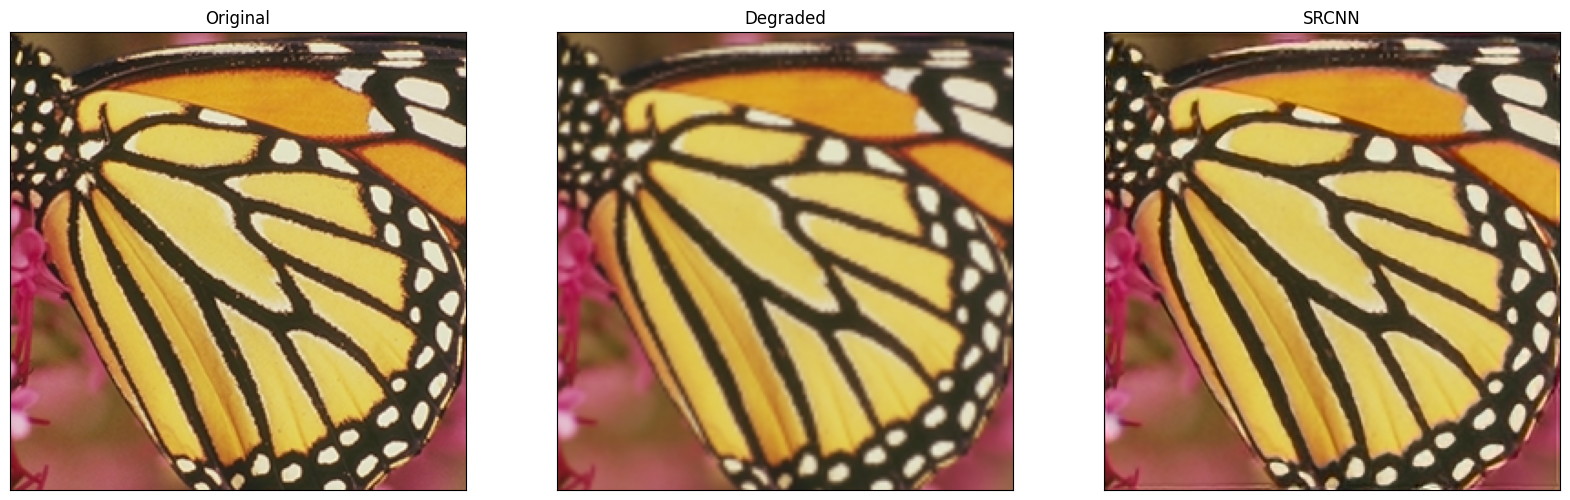

In [79]:
ref, degraded, output, scores = predict('images/butterfly_GT.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


In [80]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images\\{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('Outputs/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step
Saving baboon.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step
Saving baby_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 88s 88s/step
Saving barbara.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Saving bird_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step
Saving BrBa.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Saving butterfly_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Saving comic.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Saving face.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Saving flowers.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Saving foreman.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Saving head_GT.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step
Saving lenna.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 255s 255s/step
Saving Messi.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step
Saving monarch.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step
Saving pepper.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step
Saving ppt3.bmp
1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step
Saving scene-bw.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/